In [1]:
import pandas as pd
pd.set_option('float_format', '{:.6f}'.format)

import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import kurtosis, skew

import umap

import seaborn as sns

from os.path import isfile
import pickle
import lzma

import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [2]:
def plot_variance(axs: plt.axis, x_ticks_list: list, variance_values: list, title: str):

    cum_sum_eigenvalues = np.cumsum(variance_values)
        
    axs.bar(range(0, len(variance_values)), variance_values, alpha=0.5, align='center', label='Individual explained variance')
    axs.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    axs.set_title(title)
    axs.set_ylabel('Explained variance ratio')
    axs.set_xlabel('Principal component index')
    axs.legend(loc='center right')
    axs.set_xticks(np.arange(len(x_ticks_list)))
    axs.set_xticklabels(x_ticks_list, rotation=90)

In [3]:
def get_predictors_info(in_df: pd.DataFrame):
    result = {}

    df_len = in_df.shape[0]

    for col in in_df.columns.values:    
        current_predictor_info = {}

        is_discrete = False
        
        no_nan_series = in_df[col].loc[~in_df[col].isna()]

        current_series_difs = np.array([(x - round(x)) for x in no_nan_series])
        
        if current_series_difs.sum() == 0:
            is_discrete = True
        
        unique_in_series = sorted(np.unique(no_nan_series))

        may_be_category = False

        for idx, value in enumerate(unique_in_series[:-1:]):
            if (value + 1) == unique_in_series[idx + 1] and value >= 0:
                may_be_category = True
            else:
                may_be_category = False

        zeros_count = no_nan_series.isin([0]).sum()

        is_sparse = False

        if zeros_count / df_len > 0.5:
            is_sparse = True
            
        uniques_info = (len(unique_in_series), round(len(unique_in_series)/df_len * 100.0, ndigits=1))

        result[col] = [is_discrete, may_be_category, uniques_info, is_sparse]
    
    return pd.DataFrame(result, index=['Is discrete', 'Is sequential', 'Unique values (count, % of total)', 'Is sparce']).T

In [4]:
def make_experiment(experiment_number: int, dataset: pd.DataFrame, class_column: str, title: str, print_results=True):
    
    X = dataset.drop([class_column], axis=1)
    y = dataset[[class_column]]

    experiment_cv_scoes = list()

    score_file_name = "./data/models/rf_test_" + str(experiment_number) + ".xz"

    if print_results:
        print("Experiment #{} - {}:".format(experiment_number, title))

    if isfile(score_file_name):
        with lzma.open(score_file_name, "rb") as m_file:
            experiment_cv_scoes = pickle.load(m_file)
            if print_results:
                print("\tCV scores loaded.")
    else:
        if print_results:
            print("\tNo CV scores, calculating.")
        clf = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)

        cross_val = RepeatedStratifiedKFold(n_splits=4, random_state=42,)

        experiment_cv_scoes = cross_val_score(estimator=clf, X=X, y=y.to_numpy().flatten(), cv=cross_val, scoring='roc_auc')
            
        with lzma.open(score_file_name, "wb") as m_file:
            pickle.dump(experiment_cv_scoes, m_file)
            if print_results:
                print("\tCV scores saved.")

    if print_results:
        print("\tMean CV score is: {}".format(experiment_cv_scoes.mean()))
    else:
        return experiment_cv_scoes.mean()

**Импорт данных**

In [5]:
src_df = pd.read_csv(filepath_or_buffer='./data/pima-indians-diabetes.csv')
src_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = src_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

**Дискретность, последовательность, разряженность**

In [6]:
src_df_info = get_predictors_info(src_df.drop(['Class'], axis=1))
src_df_info

,Is discrete,Is sequential,"Unique values (count, % of total)",Is sparce
Pregnancies,True,False,"(17, 2.2)",False
Glucose,True,True,"(135, 17.6)",False
BloodPressure,True,False,"(46, 6.0)",False
SkinThickness,True,False,"(50, 6.5)",False
Insulin,True,False,"(185, 24.1)",False
BMI,False,False,"(247, 32.2)",False
DiabetesPedigreeFunction,False,False,"(517, 67.3)",False
Age,True,False,"(52, 6.8)",False


Интересно, что глюкоза оказалась последовательностью. Не знаю что это значит.

**NaN**

In [7]:
src_df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Class                         0
dtype: int64

**Импутация**

In [8]:
imputer = MissForest(max_iter=10, random_state=42, verbose=0)
    
imputed_values = imputer.fit_transform(src_df.drop(['Class'], axis=1))
imputed_df = pd.DataFrame(data=imputed_values, columns=src_df.drop(['Class'], axis=1).columns.values).join(src_df[['Class']])

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


Собственно исследование на дискретность мне нужно было, чтобы понять, какие предикторы можно округлить до int. Что должно снижать шум от ипутации. Скорее всего.

In [9]:
for col in src_df_info['Is discrete'].index:
    if src_df_info['Is discrete'][col]:
        imputed_df[col] = imputed_df[col].map(round)
        #print(col)

get_predictors_info(imputed_df.drop(['Class'], axis=1))

,Is discrete,Is sequential,"Unique values (count, % of total)",Is sparce
Pregnancies,True,False,"(17, 2.2)",False
Glucose,True,True,"(135, 17.6)",False
BloodPressure,True,False,"(53, 6.9)",False
SkinThickness,True,False,"(50, 6.5)",False
Insulin,True,False,"(286, 37.2)",False
BMI,False,False,"(258, 33.6)",False
DiabetesPedigreeFunction,False,False,"(517, 67.3)",False
Age,True,False,"(52, 6.8)",False


In [10]:
imputed_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Class                       0
dtype: int64

**Распределения**

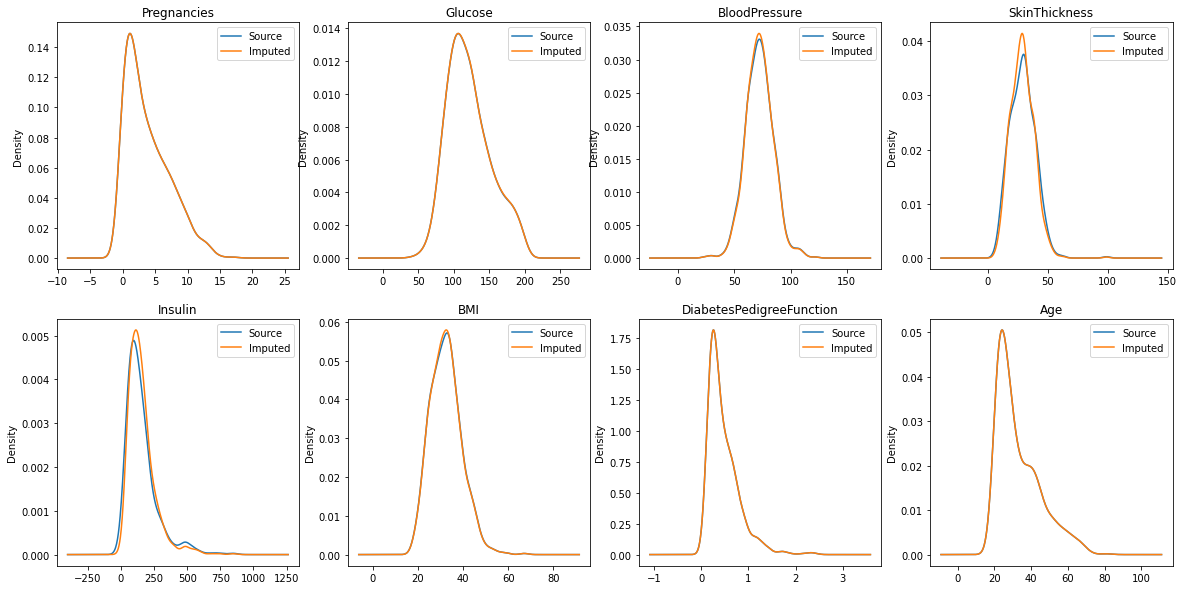

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
ax = axs.flatten()

for idx, col in enumerate(imputed_df.drop(['Class'], axis=1).columns.values):
    src_df[col].plot.density(ax=ax[idx])
    imputed_df[col].plot.density(ax=ax[idx])
    ax[idx].legend(['Source', 'Imputed'])
    ax[idx].set_title(col)

**Skewness & Kurtosis**

In [12]:
distribution_values = {}

for idx, col in enumerate(imputed_df.drop(['Class'], axis=1).columns.values):
    distribution_values[col] = [skew(imputed_df[col]), kurtosis(imputed_df[col])]
    
pd.DataFrame(data=distribution_values, index=['Skewness', 'Kurtosis']).T

,Skewness,Kurtosis
Pregnancies,0.899912,0.150383
Glucose,0.531464,-0.283699
BloodPressure,0.137197,0.982394
SkinThickness,0.695674,2.999344
Insulin,2.075999,6.755385
BMI,0.604255,0.899542
DiabetesPedigreeFunction,1.916159,5.550792
Age,1.127389,0.631177


С kurtosis я вряд-ли что-то смогу сделать, а вот с ассиметрией можно попробовать.

**Scaling + Yeo Johnson (PowerTransformer)**

In [13]:
scaled_values = PowerTransformer().fit_transform(imputed_df.drop(['Class'], axis=1))
scaled_df = pd.DataFrame(data=scaled_values, columns=imputed_df.drop(['Class'], axis=1).columns.values).join(imputed_df[['Class']])

**StandardScaler**

In [14]:
z_scaled_values = StandardScaler().fit_transform(imputed_df.drop(['Class'], axis=1))
z_scaled_df = pd.DataFrame(data=z_scaled_values, columns=imputed_df.drop(['Class'], axis=1).columns.values).join(imputed_df[['Class']])

**Сравнение**

In [15]:
temp_1 = make_experiment(2, scaled_df, 'Class', 'Scaled with PowerTransformer', print_results=False)
temp_2 = make_experiment(3, z_scaled_df, 'Class', 'Scaled with StandatdScaler', print_results=False)
temp_3 = make_experiment(1, imputed_df, 'Class', 'Imputed with MissForest', print_results=False)

print("Scores for:\n\t- Scaled with PowerTransformer: {:.6f}\n\t- Scaled with StandatdScaler: {:.6f}\n\t- Imputed with MissFores: {:.6f}".format(temp_1, temp_2, temp_3))

Scores for:
	- Scaled with PowerTransformer: 0.827763
	- Scaled with StandatdScaler: 0.828213
	- Imputed with MissFores: 0.828127


In [16]:
distribution_values = {}

for idx, col in enumerate(z_scaled_df.drop(['Class'], axis=1).columns.values):
    distribution_values[col] = [skew(z_scaled_df[col]), skew(scaled_df[col]), kurtosis(z_scaled_df[col]), kurtosis(scaled_df[col])]
    
pd.DataFrame(data=distribution_values, index=['Skewness StandardScaler', 'Skewness PowerTransformer', 'Kurtosis StandardScaler', 'Kurtosis PowerTransformer']).T

,Skewness StandardScaler,Skewness PowerTransformer,Kurtosis StandardScaler,Kurtosis PowerTransformer
Pregnancies,0.899912,-0.044557,0.150383,-0.989546
Glucose,0.531464,-0.001635,-0.283699,-0.252796
BloodPressure,0.137197,0.055911,0.982394,1.008987
SkinThickness,0.695674,0.014884,2.999344,0.503556
Insulin,2.075999,0.006106,6.755385,0.342813
BMI,0.604255,-0.000309,0.899542,-0.089159
DiabetesPedigreeFunction,1.916159,0.142043,5.550792,-0.885275
Age,1.127389,0.149926,0.631177,-1.206163


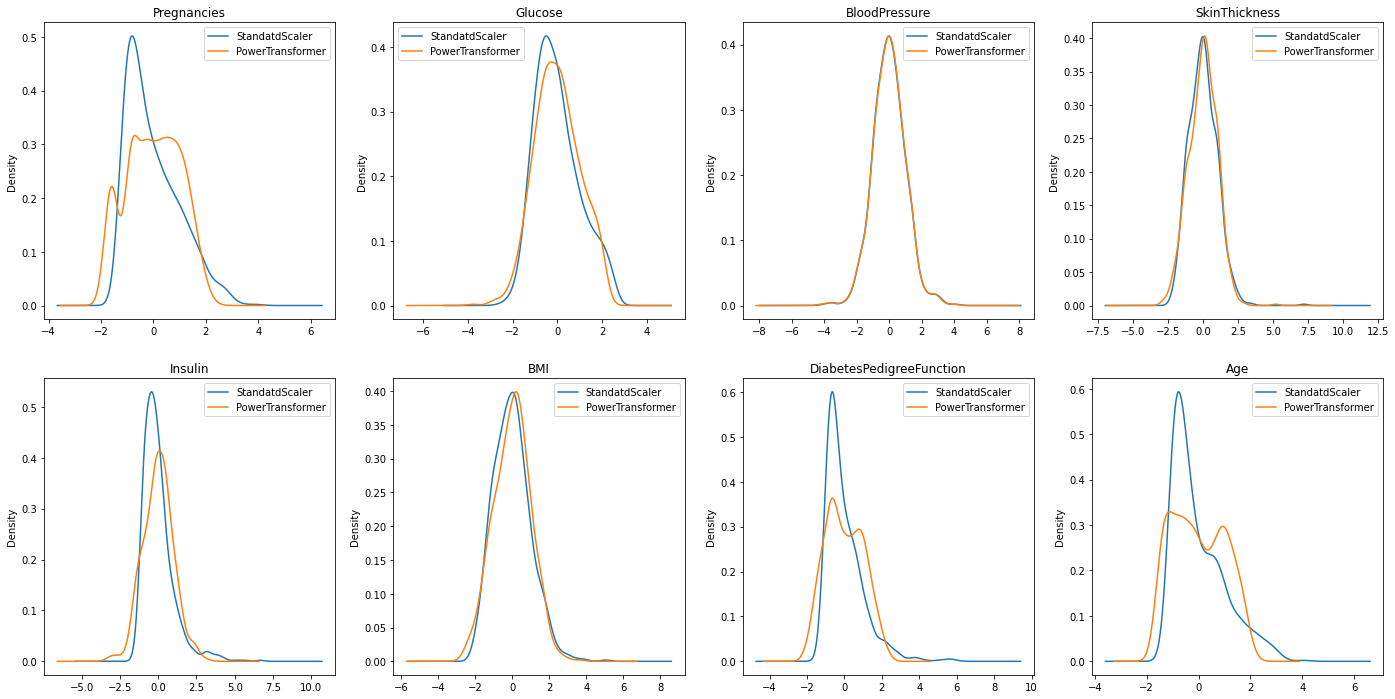

In [17]:
fig, axs = plt.subplots(2, 4, figsize=(24, 12))
ax = axs.flatten()

for idx, col in enumerate(scaled_df.drop(['Class'], axis=1).columns.values):
    z_scaled_df[col].plot.density(ax=ax[idx])
    scaled_df[col].plot.density(ax=ax[idx])
    ax[idx].set_title(col)
    ax[idx].legend(['StandatdScaler', 'PowerTransformer'])
    ax[idx].set_title(col)

Как видно, Yeo Johnson сделал своё дело и симметрия почти идеальна. По всем остальным параметрам StandardScaler и PowerTransform очень близки. 

**Correlations**

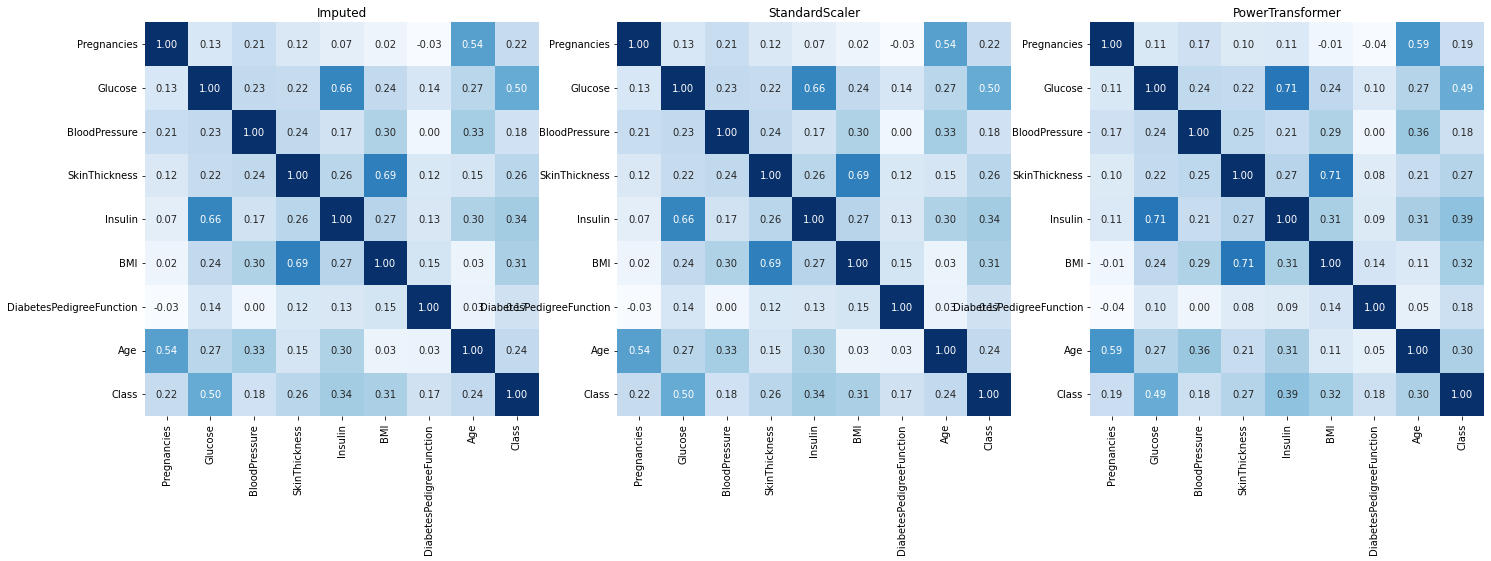

In [18]:
fig = plt.figure(figsize=(24,8))

plt.subplot(131)
plt.title('Imputed')
sns.heatmap(imputed_df.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False)


plt.subplot(132)
plt.title('StandardScaler')
sns.heatmap(z_scaled_df.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False)

plt.subplot(133) 
plt.title('PowerTransformer')
sns.heatmap(scaled_df.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False)

plt.show()

Корреляции также очень близки.

**N-dimension PCA**

Здесь я применю PCA N = 8, то есть по размерности M датасета, просто хочу посмотреть что из этого выйдет.

In [19]:
df_columns = imputed_df.drop(['Class'], axis=1).columns.values

imputed_no_class_values = imputed_df.drop(['Class'], axis=1).to_numpy()
scaled_no_class_values = scaled_df.drop(['Class'], axis=1).to_numpy()
z_scaled_no_class_values = z_scaled_df.drop(['Class'], axis=1).to_numpy()

In [20]:
PCA_8 = {}

test_cols = ['imputed', 'StandardScaler', 'PowerTransformer']

PCA_8['imputed'] = PCA(n_components=8, random_state=42)
PCA_8['imputed'].fit(X=imputed_no_class_values)

PCA_8['StandardScaler'] = PCA(n_components=8, random_state=42)
PCA_8['StandardScaler'].fit(X=z_scaled_no_class_values)

PCA_8['PowerTransformer'] = PCA(n_components=8, random_state=42)
PCA_8['PowerTransformer'].fit(X=scaled_no_class_values)

PCA_8_i_df = pd.DataFrame(PCA_8['imputed'].fit_transform(imputed_no_class_values), columns=df_columns).join(scaled_df[['Class']])
PCA_8_ss_df = pd.DataFrame(PCA_8['StandardScaler'].fit_transform(z_scaled_no_class_values), columns=df_columns).join(scaled_df[['Class']])
PCA_8_pt_df = pd.DataFrame(PCA_8['PowerTransformer'].fit_transform(scaled_no_class_values), columns=df_columns).join(scaled_df[['Class']])

PCA_8_dfs = [PCA_8_i_df, PCA_8_ss_df, PCA_8_pt_df]

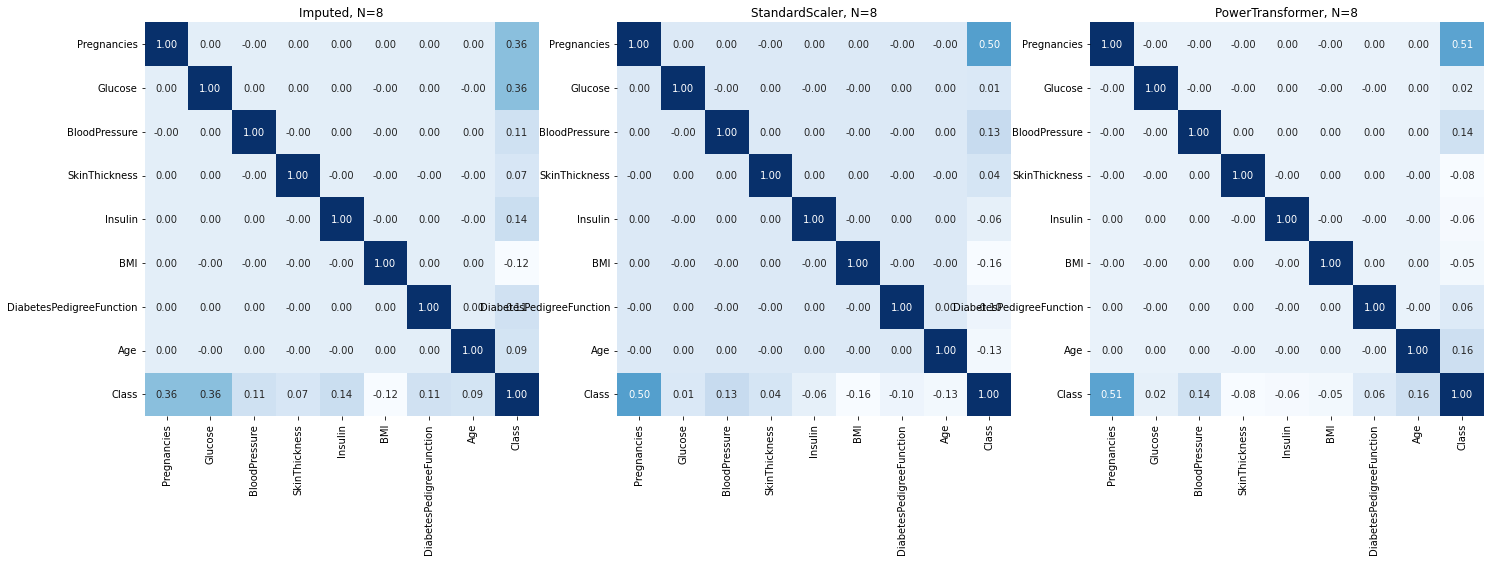

In [21]:
fig = plt.figure(figsize=(24,8))

plt.subplot(131)
plt.title('Imputed, N=8')
sns.heatmap(PCA_8_i_df.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False)


plt.subplot(132)
plt.title('StandardScaler, N=8')
sns.heatmap(PCA_8_ss_df.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False)

plt.subplot(133) 
plt.title('PowerTransformer, N=8')
sns.heatmap(PCA_8_pt_df.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False)

plt.show()

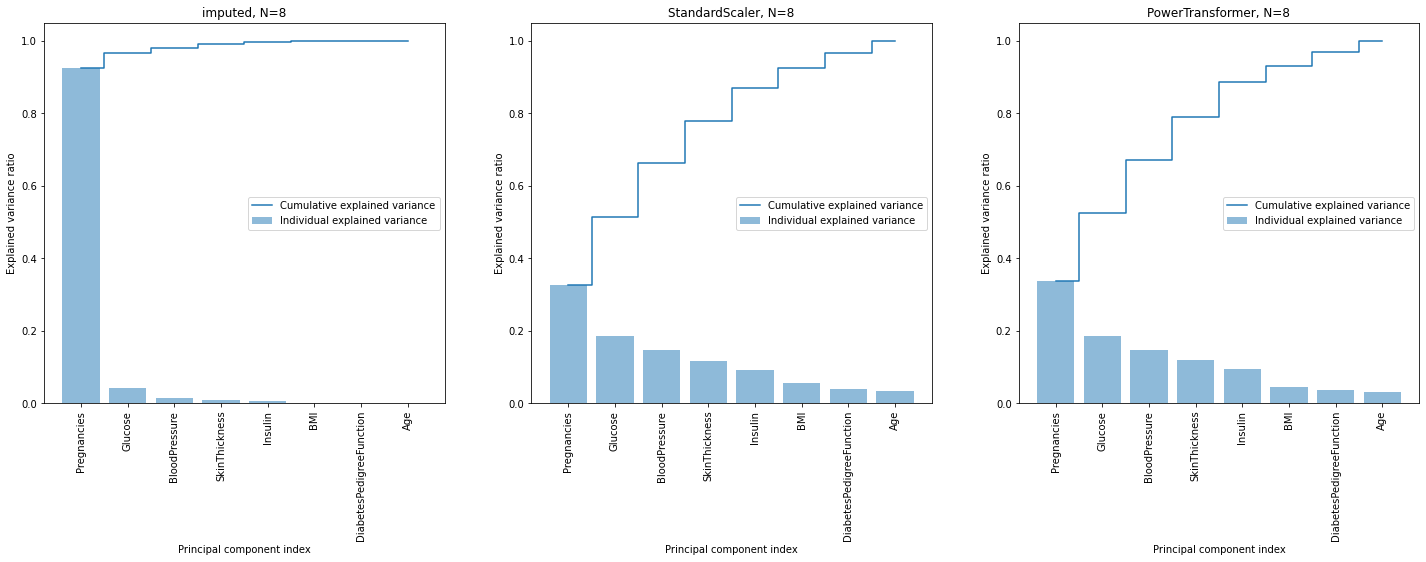

In [22]:
figure, axis = plt.subplots(1, 3, figsize=(21, 9))
axs = axis.flatten()

col_names = scaled_df.drop(['Class'], axis=1).columns.values

for idx, col in enumerate(test_cols):
    plot_variance(axs=axs[idx], variance_values=PCA_8[col].explained_variance_ratio_, x_ticks_list=col_names, title=col + ", N=8")
    
plt.tight_layout(pad=5.0)
plt.show()

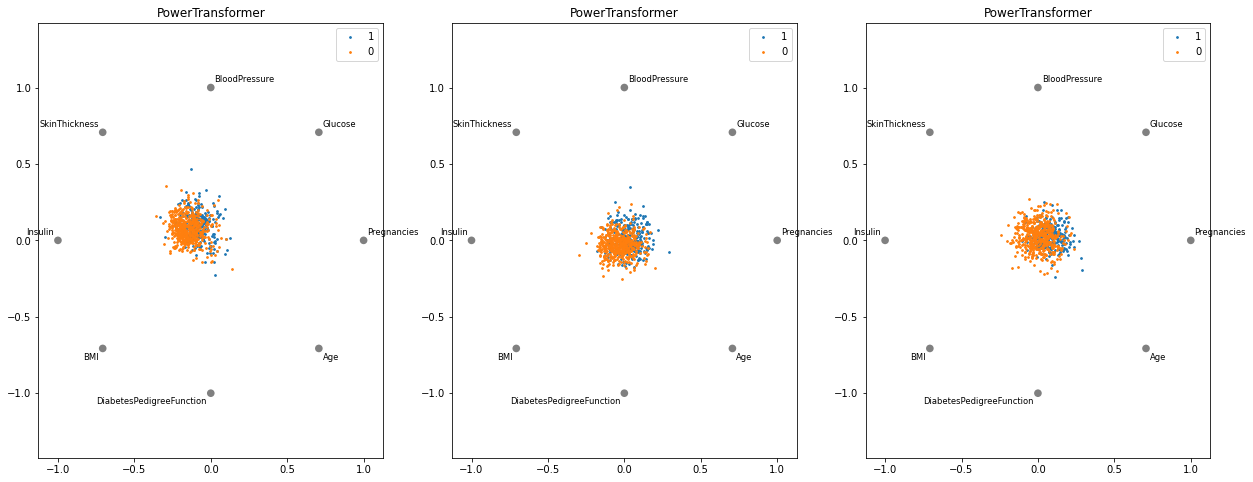

In [23]:
figure, axis = plt.subplots(1, 3, figsize=(21, 8))
axs = axis.flatten()

for idx, df in enumerate(PCA_8_dfs):
    pd.plotting.radviz(frame=df, class_column='Class', color=sns.color_palette(), s=3, ax=axs[idx])
    axs[idx].set_title(col)

plt.show()

In [24]:
pd.DataFrame(
    data=[PCA_8['imputed'].explained_variance_ratio_, PCA_8['StandardScaler'].explained_variance_ratio_, PCA_8['PowerTransformer'].explained_variance_ratio_],
    columns=df_columns,
    index = ['imputed', 'StandardScaler', 'PowerTransformer']
    )

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
imputed,0.924385,0.042086,0.014910,0.009546,0.006964,0.001471,0.000630,0.000009
StandardScaler,0.327480,0.186811,0.147677,0.116490,0.092651,0.054911,0.039371,0.034610
PowerTransformer,0.338537,0.185357,0.146208,0.120106,0.095735,0.046056,0.036771,0.031230


Наблюдается следующая картина:
1. Корреляции практически свелись к нулю. Между предикторами так ровно к нулю.
2. PowerTransformer и StandadScaler по прежнему близки по всем показателям.
3. DPF и AGE предикторы с наименьшей variance. Можно бы-ло бы и BMI убрать, но тогда я куммулятивную сумму снизил бы меньше 0.9, что противоречит поставленной задаче.
4. Визуально (RadViz) PowerTransformer имеет более разряженое распределение.

Далее я буду использовать датасет обработанный PowerTransformer.

**Декомпозиция до N=6**

In [25]:
temp_1 = make_experiment(4, scaled_df.drop(['DiabetesPedigreeFunction', 'Age'], axis=1), 'Class', 'DPF and Age dopped.', print_results=False)

PCA_6 = PCA(n_components=6, random_state=42)
pca_6_values = PCA_6.fit_transform(X=scaled_df)

X = pd.DataFrame(data=pca_6_values, columns=col_names[:6:]).join(scaled_df[['Class']])
temp_2 = make_experiment(5, X, 'Class', 'Scaled dataset decomposition to 6 components.', print_results=False)

print("Scores for:\n\t- Dropped DPF and Age features: {:.6f}\n\t- Decomposition to N=6: {:.6f}".format(temp_1, temp_2))

Scores for:
	- Dropped DPF and Age features: 0.803655
	- Decomposition to N=6: 0.836212


Тут интересно. Просто выбросить предикторы намного хуже, чем провести декомпозицию.

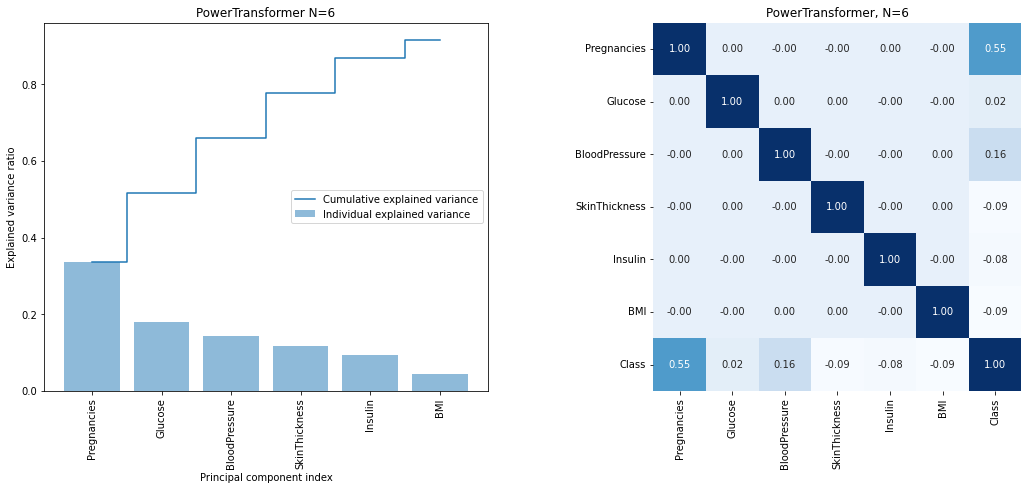

In [26]:
figure, ax = plt.subplots(1, 2, figsize=(16, 8))
axs = ax.flatten()

plot_variance(axs=axs[0], variance_values=PCA_6.explained_variance_ratio_, x_ticks_list=col_names[:6:], title="PowerTransformer N=6")

axs[1].set_title('PowerTransformer, N=6')
sns.heatmap(X.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False, ax=axs[1])

plt.tight_layout(pad=5.0)
plt.show()

**Последовательная декомпозиция**

Здесь я пошагово, с шагом один, буду проводить декомпозицию до N=2 и смотреть что получается. Корреляцию измерять не стану, поскольку с ней всё более-менее понятно.

In [27]:
tsne_results = {}
umap_results = {}
pca_results = {}

decomp_results = {'TSNE':tsne_results, 'UMAP': umap_results, 'PCA': pca_results}

if isfile("./data/models/decomp_results.xz"):
    with lzma.open("./data/models/decomp_results.xz", "rb") as m_file:
        decomp_results = pickle.load(m_file)
else:
    for idx in np.arange(2, 9, 1)[::-1]:
        print("N = {}.".format(idx))
        pca_worker = PCA(n_components=idx, random_state=42)
        tsne_worker = TSNE(n_components=idx, random_state=42, method='exact', n_jobs=-1)
        umap_worker = umap.UMAP(n_components=idx, random_state=42, n_jobs=-1)

        pca_results[idx] = pca_worker.fit_transform(scaled_no_class_values)
        tsne_results[idx] = tsne_worker.fit_transform(scaled_no_class_values)
        umap_results[idx] = umap_worker.fit_transform(scaled_no_class_values)
  
    with lzma.open("./data/models/decomp_results.xz", "wb") as m_file:
        pickle.dump(decomp_results, m_file)

In [28]:
scores = {}

idx = 1
for decompositor in decomp_results:
    scores[decompositor] = {}
    #print("Calculating scores for {} decompositor.".format(decompositor))

    for n in decomp_results[decompositor]:
        df = pd.DataFrame(data = decomp_results[decompositor][n], columns=col_names[:n:]).join(scaled_df[['Class']])
        score = make_experiment(experiment_number=(idx * 10 + n), dataset=df, class_column='Class', title='', print_results=False)
        scores[decompositor][n] = score
        #print("\tScore fo N = {} is: {:.6f}".format(n, score))
    
    idx += 1
    print()

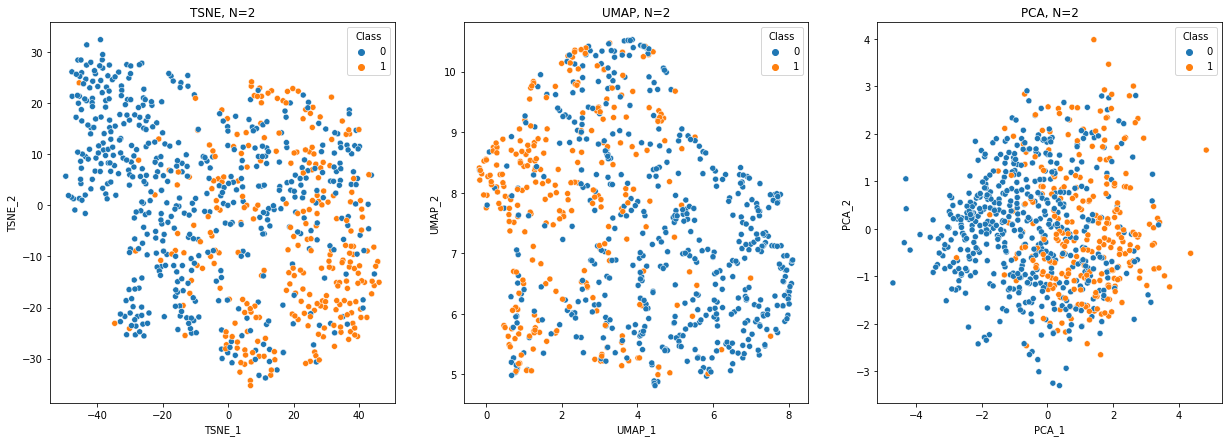

In [29]:
figure, axis = plt.subplots(1, 3, figsize=(21, 7))
axs = axis.flatten()

idx=0
for decompositor in decomp_results:
    x_col = decompositor + '_1'
    y_col = decompositor + '_2'
    df = pd.DataFrame(data = decomp_results[decompositor][2], columns=[x_col, y_col]).join(scaled_df[['Class']])
    sns.scatterplot(data=df, x=x_col, y=y_col, hue="Class", ax=axs[idx])
    axs[idx].set_title(decompositor + ", N=2")
    idx += 1
    
plt.show()

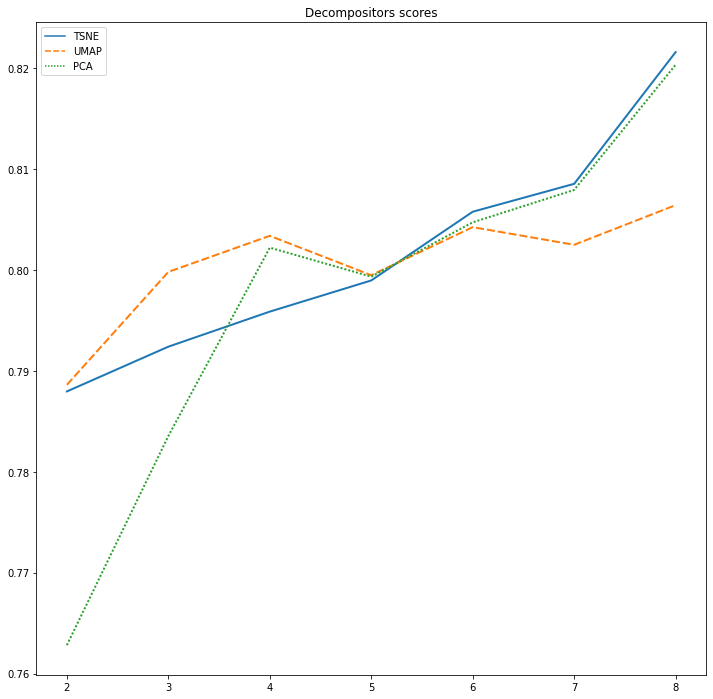

In [30]:
figure, axs = plt.subplots(1, 1, figsize=(12, 12))
colors = ['red', 'black', 'green']

scores_df = pd.DataFrame()

for decompositor in scores:
    scores_df[decompositor] = scores[decompositor].values()

scores_df.index = np.arange(2, 9, 1)[::-1]
sns.lineplot(data=scores_df, ax=axs, linewidth=2)

axs.set_title('Decompositors scores')
plt.show()

**Заключение**

Первое, что бросается в глаза, матрица корреляций. Получается декомпозиция отличный метод борьбы с коллениарностью. Что важно, можно ничего не выбрасывать из датасета.

Точность модели при декомпозиции падает, но не катастрофически. Хотя существенно. Вероятно, при большом количестве предикторов это must have техника. Посольку считать 200 и 50 предикторов это большая разница.

UMAP показывает наилучший результат при сильном снижении размерности.

TSNE самы медленный, однозначно, алгоритм. Что важно на большом количестве записей.

Не могу сказать однозначно, какой алгоритм лучше, но UMAP мне визуально больше нравится. Хотя это не объективный показатель.